<a href="https://colab.research.google.com/github/audreyemmely/masters-study-codes/blob/main/exploring_fairness_adult_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fairness analysis of adult income dataset
Dataset: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif

data_path = 'https://raw.githubusercontent.com/audreyemmely/masters-study-codes/main/datasets/adult_data.csv'
df = pd.read_csv(data_path)

In [2]:
df = df.dropna()
print(len(df))
df.head()

30162


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Exploratory analysis

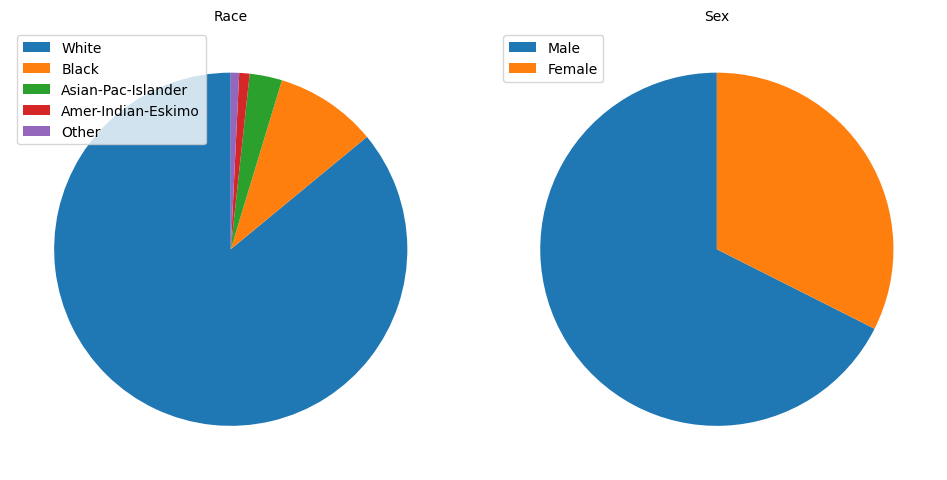

In [3]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
counts = df['race'].value_counts()
labels = counts.index
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=10)
plt.title("Race",size=10)

plt.subplot(122)
counts = df['sex'].value_counts()
labels = counts.index
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=10)
plt.title("Sex",size=10)
plt.tight_layout(pad=2)

In [4]:
df_fair = df[['race', 'sex']].copy()

# protected variables
df_fair['priv_race'] = [1 if r == 'White' else 0 for r in df_fair['race']]
df_fair['priv_sex'] = [1 if s == 'Male' else 0 for s in df_fair['sex']]

# target
df_fair['y'] = [1 if y == '>50K' else 0 for y in df['y']]

df_fair.head()

,race,sex,priv_race,priv_sex,y
0,White,Male,1,1,0
1,White,Male,1,1,0
2,White,Male,1,1,0
3,Black,Male,0,1,0
4,Black,Female,0,0,0


In [5]:
#Calculate prevelance
#prevalence is the proportion of positive cases overall cases
#prevalence = p/n
prev = df_fair['y'].mean()
prev_race = df_fair.groupby('priv_race')['y'].mean()
prev_sex = df_fair.groupby('priv_sex')['y'].mean()
prev_comb = df_fair.groupby(['priv_race','priv_sex'])['y'].mean()

print(prev)
print(prev_race)
print(prev_sex)
print(prev_comb)

0.24892248524633645
priv_race
0    0.158193
1    0.263718
Name: y, dtype: float64
priv_sex
0    0.113678
1    0.313837
Name: y, dtype: float64
priv_race  priv_sex
0          0           0.074722
           1           0.225448
1          0           0.122989
           1           0.325313
Name: y, dtype: float64


In [6]:
y = [1 if y == '>50K' else 0 for y in df['y']]

#Model features
X = df[['age','education-num','hours-per-week']].copy()
X['marital-status'] = [1 if x=='Married-civ-spouse' else 0 for x in df['marital-status']]
X['native-country'] = [1 if x=='United-States' else 0 for x in df['native-country']]

occ_groups = {
    'Priv-house-serv':0,'Other-service':0,'Handlers-cleaners':0,
    'Farming-fishing':1,'Machine-op-inspct':1,'Adm-clerical':1,
    'Transport-moving':2,'Craft-repair':2,'Sales':2,
    'Armed-Forces':3,'Tech-support':3,'Protective-serv':3,
    'Prof-specialty':4,'Exec-managerial':4}

X['occupation'] = [occ_groups[x] for x in df['occupation']]

X.head()

,age,education-num,hours-per-week,marital-status,native-country,occupation
0,39,13,40,0,1,1
1,50,13,13,1,1,4
2,38,9,40,0,1,0
3,53,7,40,1,1,0
4,28,13,40,1,0,4


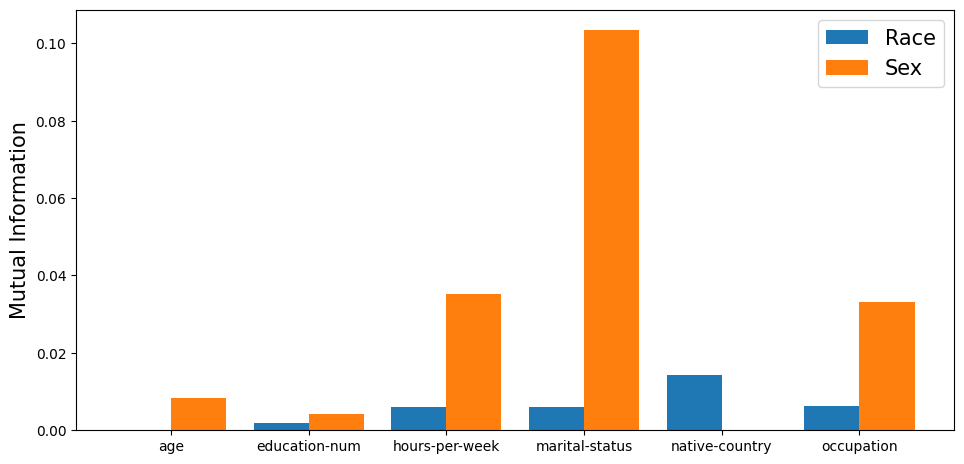

In [7]:
#Mutual information

#Calcualte mutual information
mut_race = mutual_info_classif(X,df_fair['priv_race'],discrete_features=[1,3,4,5])
mut_sex = mutual_info_classif(X,df_fair['priv_sex'],discrete_features=[1,3,4,5])


#Plot mutual information
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
       'native-country', 'occupation']
x = np.arange(len(labels))
width = 0.4
plt.bar(x-width/2,height= mut_race,width=width,label='Race')
plt.bar(x+width/2,height= mut_sex,width=width,label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Mutual Information',size=15)
plt.xticks(ticks=x,labels=labels)
plt.tight_layout(pad=2)

In [8]:
#Feature importance race

y_race_0 = df_fair[df_fair['priv_race'] == 0]['priv_race']
y_race_1 = df_fair[df_fair['priv_race'] == 1]['priv_race']
y_race_1 = y_race_1.sample(len(y_race_0))
y_race = y_race_0.append(y_race_1)

X_race = X.loc[y_race.index]

#Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_race, y_race)
y_pred = model.predict(X_race)

#Calculate accuracy
acc_race = accuracy_score(y_race, y_pred)

#Get feature importance
fi_race = model.get_booster().get_score(importance_type='weight')

#Output results
print(acc_race)
print(confusion_matrix(y_race, y_pred))
print(classification_report(y_race, y_pred))

<ipython-input-8-824510e0c749>:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_race = y_race_0.append(y_race_1)


0.7584535351146843
[[3236  993]
 [1050 3179]]
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      4229
           1       0.76      0.75      0.76      4229

    accuracy                           0.76      8458
   macro avg       0.76      0.76      0.76      8458
weighted avg       0.76      0.76      0.76      8458



In [9]:
#Feature importance sex
y_sex_0 = df_fair[df_fair['priv_sex'] == 0]['priv_sex']
y_sex_1 = df_fair[df_fair['priv_sex'] == 1]['priv_sex']
y_sex_1 = y_sex_1.sample(len(y_sex_0))
y_sex = y_sex_0.append(y_sex_1)

X_sex = X.loc[y_sex.index]

#Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_sex, y_sex)

y_pred = model.predict(X_sex)

acc_sex = accuracy_score(y_sex, y_pred)

#Get feature importance
fi_sex = model.get_booster().get_score(importance_type='weight')

#Output results
print(acc_sex)
print(confusion_matrix(y_sex, y_pred))
print(classification_report(y_sex, y_pred))

<ipython-input-9-c25155d0bca6>:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_sex = y_sex_0.append(y_sex_1)


0.7964117767327745
[[8267 1515]
 [2468 7314]]
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      9782
           1       0.83      0.75      0.79      9782

    accuracy                           0.80     19564
   macro avg       0.80      0.80      0.80     19564
weighted avg       0.80      0.80      0.80     19564



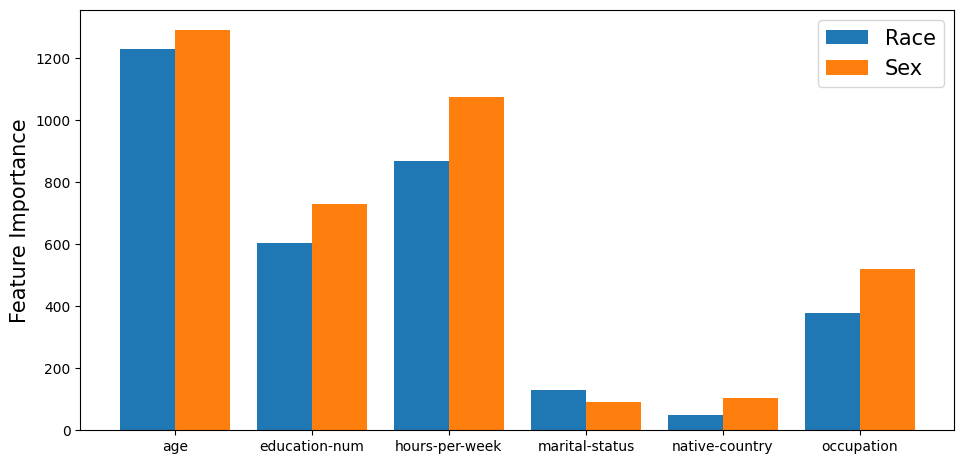

In [10]:
#Plot feature importance
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
       'native-country', 'occupation']

fi_race = [fi_race[l] for l in labels]
fi_sex = [fi_sex[l] for l in labels]


x = np.arange(len(labels))
width = 0.4
plt.bar(x-width/2,height= fi_race,width=width,label='Race')
plt.bar(x+width/2,height= fi_sex,width=width,label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Feature Importance',size=15)
plt.xticks(ticks=x,labels=labels)
plt.tight_layout(pad=2)

## Measuring fairness

In [11]:
#Train model
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X, y)

#Get predictions
y_pred = model.predict(X)
df_fair['y_pred'] = y_pred

print(confusion_matrix(y, y_pred))
print(accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

[[20955  1699]
 [ 2841  4667]]
0.8494794774882303
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     22654
           1       0.73      0.62      0.67      7508

    accuracy                           0.85     30162
   macro avg       0.81      0.77      0.79     30162
weighted avg       0.84      0.85      0.85     30162



In [12]:
def fairness_metrics(df):
    """Calculate fairness for subgroup of population"""

    #Confusion Matrix
    cm=confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()

    N = TP+FP+FN+TN

    # Overall accuracy
    ACC = (TP+TN)/N

    # True positive rate
    TPR = TP/(TP+FN)

    # False positive rate
    FPR = FP/(FP+TN)

    # False negative rate
    FNR = FN/(TP+FN)

    # Percentage predicted as positive
    PPP = (TP + FP)/N

    return np.array([ACC, TPR, FPR, FNR, PPP])

In [13]:
#Calculate fairness metrics for race
fm_race_1 = fairness_metrics(df_fair[df_fair.priv_race==1])
fm_race_0 = fairness_metrics(df_fair[df_fair.priv_race==0])

#Get ratio of fairness metrics
fm_race = fm_race_0/fm_race_1

print(fm_race_1)
print(fm_race_0)
print(fm_race)

[0.84274862 0.63108642 0.0814392  0.36891358 0.22639108]
[0.89075432 0.52466368 0.04044944 0.47533632 0.11704895]
[1.05696324 0.83136582 0.49668268 1.28847607 0.51702101]


In [14]:
#Calculate fairness metrics for sex
fm_sex_1 = fairness_metrics(df_fair[df_fair.priv_sex==1])
fm_sex_0 = fairness_metrics(df_fair[df_fair.priv_sex==0])


#Get ratio of fairness metrics
fm_sex = fm_sex_0/fm_sex_1

print(fm_sex_1)
print(fm_sex_0)
print(fm_sex)

[0.81422964 0.64993746 0.11062643 0.35006254 0.27988224]
[0.92291965 0.45863309 0.01753172 0.54136691 0.06767532]
[1.13348815 0.70565727 0.15847676 1.54648626 0.24179927]


Referência

O'SULLIVAN, C. Analysing Fairness in Machine Learning. Disponível em: https://towardsdatascience.com/analysing-fairness-in-machine-learning-with-python-96a9ab0d0705